In [25]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm


In [26]:
# Установка скоростей для тегов OSM
s1 = 100 / 3.6  # Пример: 100 км/ч в м/с
s2 = 80 / 3.6   # Пример: 80 км/ч в м/с
s3 = 50 / 3.6   # Пример: 50 км/ч в м/с
s4 = 30 / 3.6   # Пример: 30 км/ч в м/с
s5 = 5 / 3.6    # Пример: 5 км/ч в м/с

speed_dict = {
    "trunk": s1, 
    "trunk_link": s1, 
    "motorway": s1, 
    "motorway_link": s1,
    "primary": s2, 
    "primary_link": s2, 
    "secondary": s2, 
    "secondary_link": s2,
    "unclassified": s2, 
    "tertiary": s3, 
    "tertiary_link": s3, 
    "residential": s3,
    "living_street": s3, 
    "road": s4, 
    "service": s4, 
    "track": s4,
    "footway": s5, 
    "path": s5, 
    "pedestrian": s5, 
    "steps": s5,
    "cycleway": s5, 
    "bridleway": s5, 
    "corridor": s5, 
    "other": s5
}

In [27]:

# 1. Загрузка данных о городе
city_name = "Omsk, Russia"  # Выбираем нужный город
G = ox.graph_from_place(city_name, network_type='drive')
# Получение границ города
city_boundary = ox.geocode_to_gdf(city_name)


In [28]:
# Присвоение скорости каждому ребру
for u, v, k, data in G.edges(data=True, keys=True):
    highway_type = data.get('highway', 'other')
    
    # Если highway_type - это список, берем первый элемент
    if isinstance(highway_type, list):
        highway_type = highway_type[0]
    
    speed = speed_dict.get(highway_type, s5)  # Используем s5 по умолчанию
    length = data.get('length', 1)  # Длина ребра
    data['travel_time'] = length / speed  # Время в секундах


In [29]:
# 2. Определение пожарных подразделений и зданий
# Загрузка данных из Excel
fire_stations_df = pd.read_excel(f'C:\\Users\\mesla\\OneDrive\\Рабочий стол\\Git\\НИР\\firestation_megapolice.xlsx')

# Преобразование координат в объекты Point
fire_stations = gpd.GeoDataFrame({
    'name': fire_stations_df['Наименование подразделения'],
    'geometry': fire_stations_df.apply(lambda row: Point(row['Долгота'], row['Широта']), axis=1)
}, crs='EPSG:4326')

# Преобразование границ города в нужную проекцию
city_boundary = city_boundary.to_crs('EPSG:4326')

In [30]:
# Фильтрация пожарных подразделений, которые находятся в границах города
fire_stations = fire_stations[fire_stations.within(city_boundary.unary_union)]


C:\Users\mesla\AppData\Local\Temp\ipykernel_5824\3544645245.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fire_stations = fire_stations[fire_stations.within(city_boundary.unary_union)]


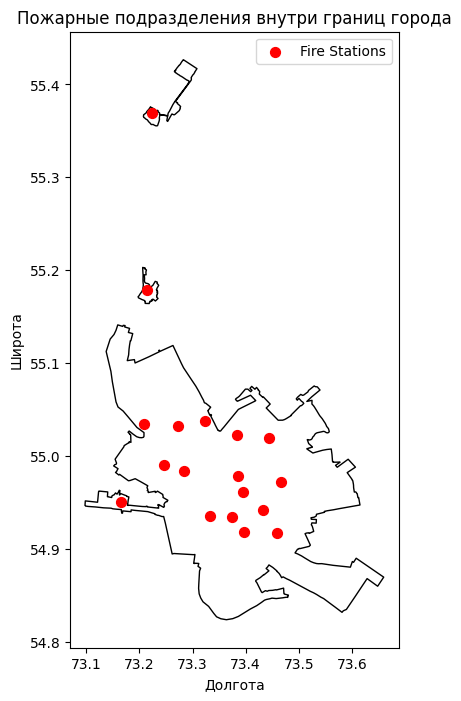

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
city_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
fire_stations.plot(ax=ax, color='red', markersize=50, label='Fire Stations')

plt.title('Пожарные подразделения внутри границ города')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend()
plt.show()

In [10]:
# 3. Загрузка зданий из OSM
# Загрузка зданий в пределах границ города
buildings = ox.features_from_polygon(city_boundary.geometry[0], tags={'building': True})


In [17]:
buildings['building_id'] = buildings.index

In [24]:
# 4. Расчет времени прибытия для каждого подразделения к каждому зданию
arrival_times = []

fire_stations['node'] = ox.distance.nearest_nodes(G, fire_stations.geometry.x, fire_stations.geometry.y)
fire_station_nodes = set(fire_stations['node'])
buildings['node'] = ox.distance.nearest_nodes(G, buildings.geometry.centroid.x, buildings.geometry.centroid.y)

for _, building in tqdm(buildings.iterrows(), total=buildings.shape[0], desc="Processing buildings"):
    end_node = building['node']
    
    for fire_node in fire_station_nodes:
        try:
            length, path = nx.single_source_dijkstra(G, source=fire_node, target=end_node, weight='travel_time')
            fire_station = fire_stations.loc[fire_stations['node'] == fire_node].iloc[0]
            
            arrival_times.append({
                'station': fire_station['name'],
                'building_id': building['building_id'],
                'travel_time': length / 60  # Перевод в минуты
            })
        except nx.NetworkXNoPath:
            continue



C:\Users\mesla\AppData\Local\Temp\ipykernel_5824\499991341.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings['node'] = ox.distance.nearest_nodes(G, buildings.geometry.centroid.x, buildings.geometry.centroid.y)
Processing buildings:   1%|          | 943/146820 [13:19<34:21:08,  1.18it/s]


KeyboardInterrupt: 

In [20]:
# Создание DataFrame для результатов
arrival_times_df = pd.DataFrame(arrival_times)

In [ ]:
# Визуализация результатов
plt.figure(figsize=(12, 8))
for station in fire_stations['name']:
    subset = arrival_times_df[arrival_times_df['station'] == station]
    plt.plot(subset['building_id'], subset['travel_time'], marker='o', label=station)

plt.xlabel('ID здания')
plt.ylabel('Время прибытия (минуты)')
plt.title('Время прибытия пожарных подразделений к зданиям')
plt.legend()
plt.grid()
plt.show()